In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## generate data

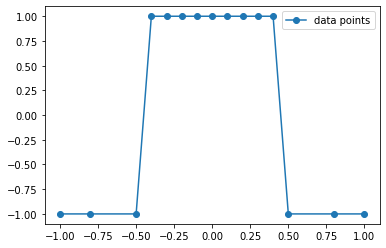

In [20]:
Nmin=-1
Nmax=1
N=15

class MyDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = {'data': float(self.data[idx]), 'label': self.label[idx]}
        return sample

    
def fun(x):
    return np.sin(x*np.pi)


data=np.array([-1,-0.8,-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5,0.8,1])*1.0
label=np.array([0,0,0,1,1,1,1,1,1,1,1,1,0,0,0])*2.0-1

train_data=data
train_label=label

plt.plot(train_data,train_label,'-o',label='data points')
plt.legend()
plt.savefig('data_points.png')

train_loader = torch.utils.data.DataLoader(dataset=MyDataset(train_data,train_label), 
                                           batch_size=N, 
                                           shuffle=False)

device = torch.device('cuda')

## Generate network

In [21]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
input_size = 1
hidden_size1 = 10000
num_classes = 1
batch_size = N


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 
        self.hidden_size1 = hidden_size1
        #self.fc1.weight.detach().normal_(0.0, 0.1)
        #self.fc1.bias.detach().normal_(0.0, 0.1)
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
        #self.fc2.weight.detach().uniform_(-1,1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = out/np.sqrt(self.hidden_size1)
        #out = out/self.hidden_size1
        return out

## Learning Regime Modification

In [22]:
def LRM(model,i,beta=1.0):
    with torch.no_grad():
        model.fc1.weight[i][0]=model.fc1.weight[i][0]/beta
        model.fc1.bias[i]=model.fc1.bias[i]/beta
        model.fc2.weight[0][i]=model.fc2.weight[0][i]*beta

def LRD(model,i):
    with torch.no_grad():
        a=model.fc1.weight[i][0].detach().clone().numpy() 
        b=model.fc1.bias[i].detach().clone().numpy() 
        c=model.fc2.weight[0][i].detach().clone().numpy()
        xx=torch.tensor(-b/a).reshape(-1, 1).to(device).float()
        fout=model(xx).numpy() 
    return [a,b,c],-b/a,c**2-a**2-b**2,fout

## Plot function

In [23]:
def plot_training(model,node_num=1000):
    plt.plot(train_data,train_label,'x',label=r'$x_j,y_j$')

    
    x= np.linspace(Nmin, Nmax, num=node_num)
    y= np.zeros(node_num)
    with torch.no_grad():
        for i in range(node_num):
            xx=torch.tensor(x[i]).reshape(-1, 1).to(device).float()
            y[i]=model(xx).to(device).cpu().numpy()
    plt.plot(x,y,'-',label=r'$x,f(x)$')
    
    

## Training

In [6]:
learning_rate = 0.0002
torch.manual_seed(0)
model = NeuralNet(input_size, hidden_size1, num_classes).to(device)
total_step = len(train_loader)
criterion=nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
num_epochs=250000
dev=100
record_list=[]
record_i=149
with torch.no_grad():
    model.fc1.weight[record_i][0]=0.5
    model.fc1.bias[record_i]=0.1
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):  



        
        
        
        # Move tensors to the configured device
        images = data['data'].reshape(-1, 1).to(device).float()
        labels = data['label'].reshape(-1, 1).to(device).float()

        #print(images,labels)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        
        
        if (epoch+1) % dev == 0 or epoch< dev:
            print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            record_list.append(LRD(model,record_i))


        
        if loss.item()<0.0003:
            break
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        



KeyboardInterrupt: ignored

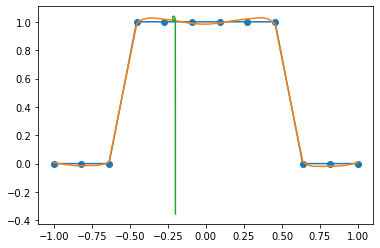

In [ ]:
plot_training(model,node_num=1000)
r=np.array(record_list)
plt.plot(r.T[1],r.T[3])

In [ ]:
learning_rate = 0.0002
torch.manual_seed(0)
model = NeuralNet(input_size, hidden_size1, num_classes).to(device)


record_list=[]
record_i=68
LRM(model,record_i,1)


total_step = len(train_loader)
criterion=nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
num_epochs=250000
dev=100





for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):  
        # Move tensors to the configured device
        images = data['data'].reshape(-1, 1).to(device).float()
        labels = data['label'].reshape(-1, 1).to(device).float()

        #print(images,labels)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        
        
        if (epoch+1) % dev == 0 or epoch< dev:
            print ('Epoch [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item()))
            record_list.append(LRD(model,record_i))

        if loss.item()<0.0001:
            break
        
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        



Epoch [1/250000], Loss: 0.5972
Epoch [2/250000], Loss: 0.5708
Epoch [3/250000], Loss: 0.5470
Epoch [4/250000], Loss: 0.5256
Epoch [5/250000], Loss: 0.5062
Epoch [6/250000], Loss: 0.4886
Epoch [7/250000], Loss: 0.4727
Epoch [8/250000], Loss: 0.4581
Epoch [9/250000], Loss: 0.4448
Epoch [10/250000], Loss: 0.4327
Epoch [11/250000], Loss: 0.4215
Epoch [12/250000], Loss: 0.4112
Epoch [13/250000], Loss: 0.4017
Epoch [14/250000], Loss: 0.3929
Epoch [15/250000], Loss: 0.3847
Epoch [16/250000], Loss: 0.3771
Epoch [17/250000], Loss: 0.3701
Epoch [18/250000], Loss: 0.3635
Epoch [19/250000], Loss: 0.3573
Epoch [20/250000], Loss: 0.3515
Epoch [21/250000], Loss: 0.3461
Epoch [22/250000], Loss: 0.3410
Epoch [23/250000], Loss: 0.3362
Epoch [24/250000], Loss: 0.3317
Epoch [25/250000], Loss: 0.3274
Epoch [26/250000], Loss: 0.3234
Epoch [27/250000], Loss: 0.3196
Epoch [28/250000], Loss: 0.3160
Epoch [29/250000], Loss: 0.3125
Epoch [30/250000], Loss: 0.3093
Epoch [31/250000], Loss: 0.3062
Epoch [32/250000]

Epoch [14800/250000], Loss: 0.0053
Epoch [14900/250000], Loss: 0.0051
Epoch [15000/250000], Loss: 0.0050
Epoch [15100/250000], Loss: 0.0049
Epoch [15200/250000], Loss: 0.0048
Epoch [15300/250000], Loss: 0.0047
Epoch [15400/250000], Loss: 0.0046
Epoch [15500/250000], Loss: 0.0045
Epoch [15600/250000], Loss: 0.0044
Epoch [15700/250000], Loss: 0.0043
Epoch [15800/250000], Loss: 0.0042
Epoch [15900/250000], Loss: 0.0041
Epoch [16000/250000], Loss: 0.0040
Epoch [16100/250000], Loss: 0.0039
Epoch [16200/250000], Loss: 0.0038
Epoch [16300/250000], Loss: 0.0037
Epoch [16400/250000], Loss: 0.0036
Epoch [16500/250000], Loss: 0.0036
Epoch [16600/250000], Loss: 0.0035
Epoch [16700/250000], Loss: 0.0034
Epoch [16800/250000], Loss: 0.0033
Epoch [16900/250000], Loss: 0.0033
Epoch [17000/250000], Loss: 0.0032
Epoch [17100/250000], Loss: 0.0031
Epoch [17200/250000], Loss: 0.0031
Epoch [17300/250000], Loss: 0.0030
Epoch [17400/250000], Loss: 0.0029
Epoch [17500/250000], Loss: 0.0029
Epoch [17600/250000]

Epoch [38300/250000], Loss: 0.0005
Epoch [38400/250000], Loss: 0.0005
Epoch [38500/250000], Loss: 0.0005
Epoch [38600/250000], Loss: 0.0005
Epoch [38700/250000], Loss: 0.0004
Epoch [38800/250000], Loss: 0.0004
Epoch [38900/250000], Loss: 0.0004
Epoch [39000/250000], Loss: 0.0004
Epoch [39100/250000], Loss: 0.0004
Epoch [39200/250000], Loss: 0.0004
Epoch [39300/250000], Loss: 0.0004
Epoch [39400/250000], Loss: 0.0004
Epoch [39500/250000], Loss: 0.0004
Epoch [39600/250000], Loss: 0.0004
Epoch [39700/250000], Loss: 0.0004
Epoch [39800/250000], Loss: 0.0004
Epoch [39900/250000], Loss: 0.0004
Epoch [40000/250000], Loss: 0.0004
Epoch [40100/250000], Loss: 0.0004
Epoch [40200/250000], Loss: 0.0004
Epoch [40300/250000], Loss: 0.0004
Epoch [40400/250000], Loss: 0.0004
Epoch [40500/250000], Loss: 0.0004
Epoch [40600/250000], Loss: 0.0004
Epoch [40700/250000], Loss: 0.0004
Epoch [40800/250000], Loss: 0.0004
Epoch [40900/250000], Loss: 0.0004
Epoch [41000/250000], Loss: 0.0004
Epoch [41100/250000]

Epoch [62200/250000], Loss: 0.0003
Epoch [62300/250000], Loss: 0.0003
Epoch [62400/250000], Loss: 0.0003
Epoch [62500/250000], Loss: 0.0003
Epoch [62600/250000], Loss: 0.0003
Epoch [62700/250000], Loss: 0.0003
Epoch [62800/250000], Loss: 0.0003
Epoch [62900/250000], Loss: 0.0003
Epoch [63000/250000], Loss: 0.0003
Epoch [63100/250000], Loss: 0.0003
Epoch [63200/250000], Loss: 0.0003
Epoch [63300/250000], Loss: 0.0003
Epoch [63400/250000], Loss: 0.0003
Epoch [63500/250000], Loss: 0.0003
Epoch [63600/250000], Loss: 0.0003
Epoch [63700/250000], Loss: 0.0003
Epoch [63800/250000], Loss: 0.0003
Epoch [63900/250000], Loss: 0.0003
Epoch [64000/250000], Loss: 0.0003
Epoch [64100/250000], Loss: 0.0003
Epoch [64200/250000], Loss: 0.0003
Epoch [64300/250000], Loss: 0.0003
Epoch [64400/250000], Loss: 0.0003
Epoch [64500/250000], Loss: 0.0003
Epoch [64600/250000], Loss: 0.0003
Epoch [64700/250000], Loss: 0.0003
Epoch [64800/250000], Loss: 0.0003
Epoch [64900/250000], Loss: 0.0003
Epoch [65000/250000]

Epoch [85900/250000], Loss: 0.0002
Epoch [86000/250000], Loss: 0.0002
Epoch [86100/250000], Loss: 0.0002
Epoch [86200/250000], Loss: 0.0002
Epoch [86300/250000], Loss: 0.0002
Epoch [86400/250000], Loss: 0.0002
Epoch [86500/250000], Loss: 0.0002
Epoch [86600/250000], Loss: 0.0002
Epoch [86700/250000], Loss: 0.0002
Epoch [86800/250000], Loss: 0.0002
Epoch [86900/250000], Loss: 0.0002
Epoch [87000/250000], Loss: 0.0002
Epoch [87100/250000], Loss: 0.0002
Epoch [87200/250000], Loss: 0.0002
Epoch [87300/250000], Loss: 0.0002
Epoch [87400/250000], Loss: 0.0002
Epoch [87500/250000], Loss: 0.0002
Epoch [87600/250000], Loss: 0.0002
Epoch [87700/250000], Loss: 0.0002
Epoch [87800/250000], Loss: 0.0002
Epoch [87900/250000], Loss: 0.0002
Epoch [88000/250000], Loss: 0.0002
Epoch [88100/250000], Loss: 0.0002
Epoch [88200/250000], Loss: 0.0002
Epoch [88300/250000], Loss: 0.0002
Epoch [88400/250000], Loss: 0.0002
Epoch [88500/250000], Loss: 0.0002
Epoch [88600/250000], Loss: 0.0002
Epoch [88700/250000]

Epoch [109600/250000], Loss: 0.0001
Epoch [109700/250000], Loss: 0.0001
Epoch [109800/250000], Loss: 0.0001
Epoch [109900/250000], Loss: 0.0001
Epoch [110000/250000], Loss: 0.0001
Epoch [110100/250000], Loss: 0.0001
Epoch [110200/250000], Loss: 0.0001
Epoch [110300/250000], Loss: 0.0001
Epoch [110400/250000], Loss: 0.0001
Epoch [110500/250000], Loss: 0.0001
Epoch [110600/250000], Loss: 0.0001
Epoch [110700/250000], Loss: 0.0001
Epoch [110800/250000], Loss: 0.0001
Epoch [110900/250000], Loss: 0.0001
Epoch [111000/250000], Loss: 0.0001
Epoch [111100/250000], Loss: 0.0001
Epoch [111200/250000], Loss: 0.0001
Epoch [111300/250000], Loss: 0.0001
Epoch [111400/250000], Loss: 0.0001
Epoch [111500/250000], Loss: 0.0001
Epoch [111600/250000], Loss: 0.0001
Epoch [111700/250000], Loss: 0.0001
Epoch [111800/250000], Loss: 0.0001
Epoch [111900/250000], Loss: 0.0001
Epoch [112000/250000], Loss: 0.0001
Epoch [112100/250000], Loss: 0.0001
Epoch [112200/250000], Loss: 0.0001
Epoch [112300/250000], Loss:

Epoch [132600/250000], Loss: 0.0001
Epoch [132700/250000], Loss: 0.0001
Epoch [132800/250000], Loss: 0.0001
Epoch [132900/250000], Loss: 0.0001
Epoch [133000/250000], Loss: 0.0001
Epoch [133100/250000], Loss: 0.0001
Epoch [133200/250000], Loss: 0.0001
Epoch [133300/250000], Loss: 0.0001
Epoch [133400/250000], Loss: 0.0001
Epoch [133500/250000], Loss: 0.0001
Epoch [133600/250000], Loss: 0.0001
Epoch [133700/250000], Loss: 0.0001
Epoch [133800/250000], Loss: 0.0001
Epoch [133900/250000], Loss: 0.0001
Epoch [134000/250000], Loss: 0.0001
Epoch [134100/250000], Loss: 0.0001
Epoch [134200/250000], Loss: 0.0001
Epoch [134300/250000], Loss: 0.0001
Epoch [134400/250000], Loss: 0.0001
Epoch [134500/250000], Loss: 0.0001
Epoch [134600/250000], Loss: 0.0001
Epoch [134700/250000], Loss: 0.0001
Epoch [134800/250000], Loss: 0.0001
Epoch [134900/250000], Loss: 0.0001
Epoch [135000/250000], Loss: 0.0001
Epoch [135100/250000], Loss: 0.0001
Epoch [135200/250000], Loss: 0.0001
Epoch [135300/250000], Loss:

Epoch [156100/250000], Loss: 0.0001
Epoch [156200/250000], Loss: 0.0001
Epoch [156300/250000], Loss: 0.0001
Epoch [156400/250000], Loss: 0.0001
Epoch [156500/250000], Loss: 0.0001
Epoch [156600/250000], Loss: 0.0001
Epoch [156700/250000], Loss: 0.0001
Epoch [156800/250000], Loss: 0.0001
Epoch [156900/250000], Loss: 0.0001
Epoch [157000/250000], Loss: 0.0001
Epoch [157100/250000], Loss: 0.0001
Epoch [157200/250000], Loss: 0.0001
Epoch [157300/250000], Loss: 0.0001
Epoch [157400/250000], Loss: 0.0001
Epoch [157500/250000], Loss: 0.0001
Epoch [157600/250000], Loss: 0.0001
Epoch [157700/250000], Loss: 0.0001
Epoch [157800/250000], Loss: 0.0001
Epoch [157900/250000], Loss: 0.0001
Epoch [158000/250000], Loss: 0.0001
Epoch [158100/250000], Loss: 0.0001
Epoch [158200/250000], Loss: 0.0001
Epoch [158300/250000], Loss: 0.0001
Epoch [158400/250000], Loss: 0.0001
Epoch [158500/250000], Loss: 0.0001
Epoch [158600/250000], Loss: 0.0001
Epoch [158700/250000], Loss: 0.0001
Epoch [158800/250000], Loss:

Epoch [179600/250000], Loss: 0.0001
Epoch [179700/250000], Loss: 0.0001
Epoch [179800/250000], Loss: 0.0001
Epoch [179900/250000], Loss: 0.0001
Epoch [180000/250000], Loss: 0.0001
Epoch [180100/250000], Loss: 0.0001
Epoch [180200/250000], Loss: 0.0001
Epoch [180300/250000], Loss: 0.0001
Epoch [180400/250000], Loss: 0.0001
Epoch [180500/250000], Loss: 0.0001
Epoch [180600/250000], Loss: 0.0001
Epoch [180700/250000], Loss: 0.0001
Epoch [180800/250000], Loss: 0.0001
Epoch [180900/250000], Loss: 0.0001
Epoch [181000/250000], Loss: 0.0001
Epoch [181100/250000], Loss: 0.0001
Epoch [181200/250000], Loss: 0.0001
Epoch [181300/250000], Loss: 0.0001
Epoch [181400/250000], Loss: 0.0001
Epoch [181500/250000], Loss: 0.0001
Epoch [181600/250000], Loss: 0.0001
Epoch [181700/250000], Loss: 0.0001
Epoch [181800/250000], Loss: 0.0001
Epoch [181900/250000], Loss: 0.0001
Epoch [182000/250000], Loss: 0.0001
Epoch [182100/250000], Loss: 0.0001
Epoch [182200/250000], Loss: 0.0001
Epoch [182300/250000], Loss:

Epoch [202600/250000], Loss: 0.0001
Epoch [202700/250000], Loss: 0.0001
Epoch [202800/250000], Loss: 0.0001
Epoch [202900/250000], Loss: 0.0001
Epoch [203000/250000], Loss: 0.0001
Epoch [203100/250000], Loss: 0.0001
Epoch [203200/250000], Loss: 0.0001
Epoch [203300/250000], Loss: 0.0001
Epoch [203400/250000], Loss: 0.0001
Epoch [203500/250000], Loss: 0.0001
Epoch [203600/250000], Loss: 0.0001
Epoch [203700/250000], Loss: 0.0001
Epoch [203800/250000], Loss: 0.0001
Epoch [203900/250000], Loss: 0.0001
Epoch [204000/250000], Loss: 0.0001
Epoch [204100/250000], Loss: 0.0001
Epoch [204200/250000], Loss: 0.0001
Epoch [204300/250000], Loss: 0.0001
Epoch [204400/250000], Loss: 0.0001
Epoch [204500/250000], Loss: 0.0001
Epoch [204600/250000], Loss: 0.0001
Epoch [204700/250000], Loss: 0.0001
Epoch [204800/250000], Loss: 0.0001
Epoch [204900/250000], Loss: 0.0001
Epoch [205000/250000], Loss: 0.0001
Epoch [205100/250000], Loss: 0.0001
Epoch [205200/250000], Loss: 0.0001
Epoch [205300/250000], Loss:

Epoch [225800/250000], Loss: 0.0001
Epoch [225900/250000], Loss: 0.0001
Epoch [226000/250000], Loss: 0.0001
Epoch [226100/250000], Loss: 0.0001
Epoch [226200/250000], Loss: 0.0001
Epoch [226300/250000], Loss: 0.0001
Epoch [226400/250000], Loss: 0.0001
Epoch [226500/250000], Loss: 0.0001
Epoch [226600/250000], Loss: 0.0001
Epoch [226700/250000], Loss: 0.0001
Epoch [226800/250000], Loss: 0.0001
Epoch [226900/250000], Loss: 0.0001
Epoch [227000/250000], Loss: 0.0001
Epoch [227100/250000], Loss: 0.0001
Epoch [227200/250000], Loss: 0.0001
Epoch [227300/250000], Loss: 0.0001
Epoch [227400/250000], Loss: 0.0001
Epoch [227500/250000], Loss: 0.0001
Epoch [227600/250000], Loss: 0.0001
Epoch [227700/250000], Loss: 0.0001
Epoch [227800/250000], Loss: 0.0001
Epoch [227900/250000], Loss: 0.0001
Epoch [228000/250000], Loss: 0.0001
Epoch [228100/250000], Loss: 0.0001
Epoch [228200/250000], Loss: 0.0001
Epoch [228300/250000], Loss: 0.0001
Epoch [228400/250000], Loss: 0.0001
Epoch [228500/250000], Loss:

Epoch [249400/250000], Loss: 0.0001
Epoch [249500/250000], Loss: 0.0001
Epoch [249600/250000], Loss: 0.0001
Epoch [249700/250000], Loss: 0.0001
Epoch [249800/250000], Loss: 0.0001
Epoch [249900/250000], Loss: 0.0001
Epoch [250000/250000], Loss: 0.0001


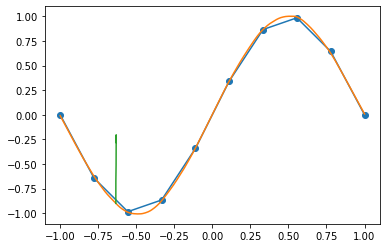

In [ ]:
plot_training(model,node_num=1000)
r=np.array(record_list)
plt.plot(r.T[1],r.T[3],'-')

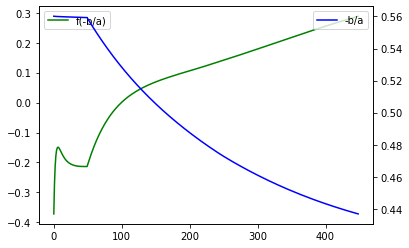

In [ ]:
fig, ax1 = plt.subplots()


ax2 = ax1.twinx()

ax1.plot(r.T[3],'g-',label='f(-b/a)')
ax2.plot(r.T[1],'b-',label='-b/a',)
ax1.legend()
ax2.legend()

In [ ]:
r.T[2]

array([-1356.7047, -1356.6946, -1356.6945, -1356.6941, -1356.694,
       -1356.6938, -1356.6937, -1356.6936, -1356.6935, -1356.6936,
       -1356.6934, -1356.6932, -1356.6934, -1356.6931, -1356.6932,
       -1356.6932, -1356.6932, -1356.6932, -1356.6932, -1356.6931,
       -1356.693, -1356.693, -1356.6929, -1356.6929, -1356.6927,
       -1356.6929, -1356.6927, -1356.6927, -1356.6926, -1356.6927,
       -1356.6929, -1356.6927, -1356.6927, -1356.6927, -1356.6929,
       -1356.6929, -1356.693, -1356.693, -1356.6931, -1356.6934,
       -1356.6934, -1356.6934, -1356.6935, -1356.6936, -1356.6937,
       -1356.6936, -1356.6935, -1356.6934, -1356.6932, -1356.6931,
       -1356.6931, -1356.693, -1356.693, -1356.6929, -1356.6929,
       -1356.6927, -1356.6926, -1356.6926, -1356.6925, -1356.6925,
       -1356.6924, -1356.6924, -1356.6924, -1356.6923, -1356.6924,
       -1356.6924, -1356.6923, -1356.6923, -1356.6923, -1356.6923,
       -1356.6921, -1356.6923, -1356.6923, -1356.6923, -1356.6923,
  

In [ ]:
a=model.fc2.weight

In [ ]:
print(a)

Parameter containing:
tensor([[ 1.7541e-02,  5.6650e-03, -2.1592e-03,  1.6352e-02, -1.5448e-03,
         -1.5505e-03, -3.4646e-03,  1.6028e-01, -1.5324e-02,  2.9569e-02,
         -2.3085e-01,  4.6899e-02, -4.4282e-02,  1.0153e-02,  9.1451e-02,
          6.8850e-03,  1.3711e-02, -7.0831e-02, -1.4862e-01,  4.2655e-02,
         -1.2158e-02,  1.5038e-01,  8.2074e-04, -9.8956e-02,  2.5396e-02,
          1.0671e-03,  1.9572e-01, -1.6289e-01, -6.9162e-02,  1.3989e-02,
         -1.9535e-02,  2.0636e-01,  7.5633e-02, -9.6528e-02,  4.8081e-02,
         -1.9960e-01,  1.2117e-02, -1.9965e-01,  2.0838e-02,  1.7299e-02,
         -7.9967e-03, -1.6197e-02,  2.2008e-02, -1.1092e-01,  1.3715e-01,
         -1.2051e-01,  4.5454e-02, -1.1291e-01, -1.6526e-02, -8.4650e-03,
         -1.5500e-01, -7.7824e-02,  1.9230e-02, -3.7071e-03, -3.2104e-03,
          9.4403e-02,  3.6377e-02,  3.0509e-02, -4.6616e-02, -8.9318e-02,
          1.2211e-02,  2.9213e-02,  9.8799e-02,  2.1746e-02,  1.2065e-01,
          3.0778

In [ ]:
learning_rate = 0.001
torch.manual_seed(0)
model = NeuralNet(input_size, hidden_size1, num_classes).to(device)

In [ ]:
with torch.no_grad():
    a=model.fc1.weight
    b=model.fc1.bias

In [ ]:
a=a.detach().numpy()
b=b.detach().numpy()


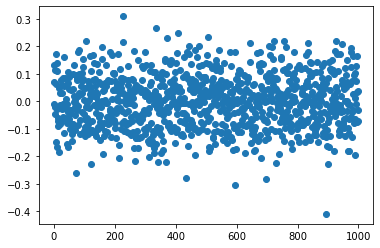

In [ ]:
plt.plot(w,'o')

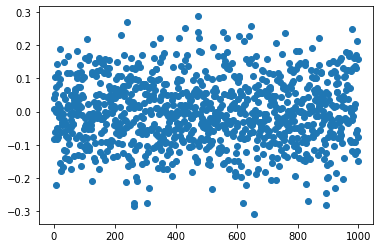

In [ ]:
with torch.no_grad():
    w=model.fc2.weight.reshape(-1)
w=w.detach().numpy()
plt.plot(w,'o')

In [ ]:
import seaborn as sns

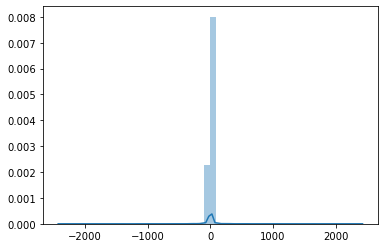

In [ ]:
sns.distplot(b/a);

In [ ]:
rlist=[]

In [ ]:
rlist.append([r,100])

In [ ]:
r10=r

In [ ]:
r100=r

In [ ]:
#r01=r

In [ ]:
#r001=r

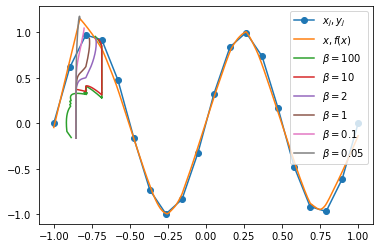

In [ ]:
plot_training(model,node_num=1000)
r=np.array(record_list)
plt.plot(r100.T[1],r100.T[3],'-',label=r'$\beta=100$')
plt.plot(r10.T[1],r10.T[3],'-',label=r'$\beta=10$')
plt.plot(r2.T[1],r2.T[3],'-',label=r'$\beta=2$')
plt.plot(r1.T[1],r1.T[3],'-',label=r'$\beta=1$')
plt.plot(r01.T[1],r01.T[3],'-',label=r'$\beta=0.1$')
plt.plot(r005.T[1],r005.T[3],'-',label=r'$\beta=0.05$')
plt.legend()
plt.savefig('node18.png')

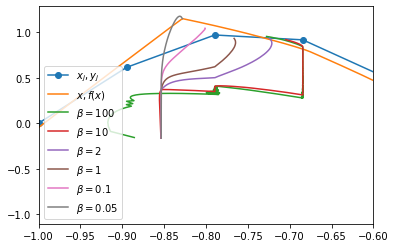

In [ ]:
plot_training(model,node_num=1000)
r=np.array(record_list)
plt.plot(r100.T[1],r100.T[3],'-',label=r'$\beta=100$')
plt.plot(r10.T[1],r10.T[3],'-',label=r'$\beta=10$')
plt.plot(r2.T[1],r2.T[3],'-',label=r'$\beta=2$')
plt.plot(r1.T[1],r1.T[3],'-',label=r'$\beta=1$')
plt.plot(r01.T[1],r01.T[3],'-',label=r'$\beta=0.1$')
plt.plot(r005.T[1],r005.T[3],'-',label=r'$\beta=0.05$')
plt.legend()
plt.xlim([-1,-0.6])
#plt.ylim([-0.75,0.75])
plt.savefig('node18zoom.png')

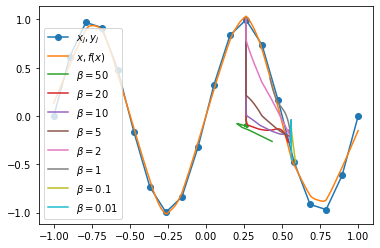

In [ ]:
plot_training(model,node_num=1000)
r=np.array(record_list)
plt.plot(r50.T[1],r50.T[3],'-',label=r'$\beta=50$')
plt.plot(r20.T[1],r20.T[3],'-',label=r'$\beta=20$')
plt.plot(r10.T[1],r10.T[3],'-',label=r'$\beta=10$')
plt.plot(r5.T[1],r5.T[3],'-',label=r'$\beta=5$')
plt.plot(r2.T[1],r2.T[3],'-',label=r'$\beta=2$')
plt.plot(r1.T[1],r1.T[3],'-',label=r'$\beta=1$')
plt.plot(r01.T[1],r01.T[3],'-',label=r'$\beta=0.1$')
plt.plot(r001.T[1],r001.T[3],'-',label=r'$\beta=0.01$')
plt.legend()
plt.savefig('node10.png')

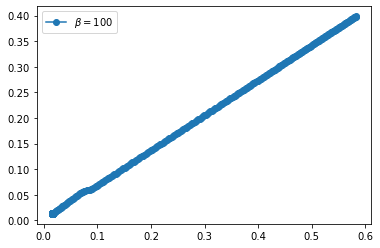

In [ ]:
plt.plot(r100[0]*r100[2],r100[1]*r100[2],'-o',label=r'$\beta=100$')
#plt.plot(r20[0]*r20[2],r20[1]*r20[2],'-',label=r'$\beta=20$')
#plt.plot(r10[0]*r10[2],r10[1]*r10[2],'-',label=r'$\beta=10$')
#plt.plot(r5[0]*r5[2],r5[1]*r5[2],'-',label=r'$\beta=5$')
#plt.plot(r2[0]*r2[2],r2[1]*r2[2],'-',label=r'$\beta=2$')
#plt.plot(r1[0]*r1[2],r1[1]*r1[2],'-',label=r'$\beta=1$')
#plt.plot(r01[0]*r01[2],r01[1]*r01[2],'-',label=r'$\beta=0.1$')
#plt.plot(r001[0]*r001[2],r001[1]*r001[2],'-',label=r'$\beta=0.01$')
plt.legend()

In [ ]:
r50.T[0][1][1]

array(0.00195552, dtype=float32)

In [ ]:
r50[1]

array([list([array(-0.005733, dtype=float32), array(0.00195552, dtype=float32), array(-1.083073, dtype=float32)]),
       0.34109917, 1.1730105, array([[-0.19196181]], dtype=float32)],
      dtype=object)

In [ ]:
rlod=np.zeros([3,399])
for i in range(399):
    rlod[0,i]=r.T[0][i][0]
    rlod[1,i]=r.T[0][i][1]
    rlod[2,i]=r.T[0][i][2]
r=rlod

In [ ]:
r50

array([[-0.00586763, -0.005733  , -0.00560957, ..., -0.26255909,
        -0.26270214, -0.26284373],
       [ 0.0025475 ,  0.00195552,  0.00159049, ...,  0.0676181 ,
         0.06759693,  0.06757472],
       [-1.08307517, -1.08307302, -1.08307171, ..., -1.11646783,
        -1.1165036 , -1.11653936]])

In [ ]:
torch.manual_seed(0)
model = NeuralNet(input_size, hidden_size1, num_classes).to(device)

LRD(model,68)

([array(0.6203766, dtype=float32),
  array(0.39197516, dtype=float32),
  array(-0.02127586, dtype=float32)],
 -0.6318342,
 -0.538059,
 array([[-0.28184396]], dtype=float32))

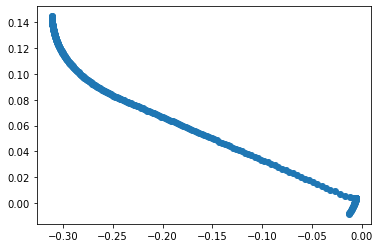

In [ ]:
plt.plot(r100[0]*r100[2],r100[1]*r100[2],'-',label=r'$\beta=100$')

In [ ]:
r100=r

In [ ]:
loss.item()

3.067180296056904e-05

## var_beta

In [24]:
def var_beta(record_i,beta=1,learning_rate = 0.0002,num_epochs=250000,dev=100):
    learning_rate = learning_rate
    torch.manual_seed(0)
    model = NeuralNet(input_size, hidden_size1, num_classes).to(device)


    record_list=[]
    record_i=record_i

    with torch.no_grad():
        model.fc1.weight[record_i][0]=1
        model.fc1.bias[record_i]=-0.4
    LRM(model,record_i,beta)


    total_step = len(train_loader)
    criterion=nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    num_epochs=num_epochs
    dev=dev

    outdis = display(progress(0, 100), display_id=True)
    


    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):  

            if epoch==10000 or epoch==100000:
                learning_rate=learning_rate*10
                optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
            images = data['data'].reshape(-1, 1).to(device).float()
            labels = data['label'].reshape(-1, 1).to(device).float()





            if (epoch+1) % dev == 0 or epoch< dev:
                outdis.update(progress(outdis.update(progress(100.*epoch/num_epochs, 100)), 100))
                with torch.no_grad():
                    x=-model.fc1.bias[record_i]/model.fc1.weight[record_i][0].reshape(-1, 1).to(device).float()
                    record_list.append([x,model(x)])

            # Backward and optimize

            outputs = model(images).to(device)
            loss = criterion(outputs, labels).to(device)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if loss.item()<0.0002:
                break
    return np.array(record_list),loss.item(),model


In [25]:
import copy

In [26]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt

from IPython.display import HTML, display

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))







Mounted at /content/drive


In [27]:
#for beta in [1,10,100,200]:
for beta in [1]:
#for beta in [1,70,100,200]:
    
        r,loss,model=var_beta(10,beta=beta,learning_rate = 0.000001,num_epochs=300000,dev=1000)
        print(beta,loss)
        plt.plot(r.T[0],r.T[1],'-',label=r'\beta='+str(beta/2))
        if beta==1:
    

            keepmodel=copy.deepcopy(model)
        
    
    
        plot_training(keepmodel,node_num=1000)    

plt.legend()
plt.savefig('/content/drive/My Drive/LCNN/plot/hahaha4.pdf')

RuntimeError: ignored

1 9.999990288633853e-05
10 9.999953181250021e-05
20 9.999939356930554e-05
30 9.999875328503549e-05
40 9.999915346270427e-05
50 9.999918256653473e-05
100 9.999940084526315e-05


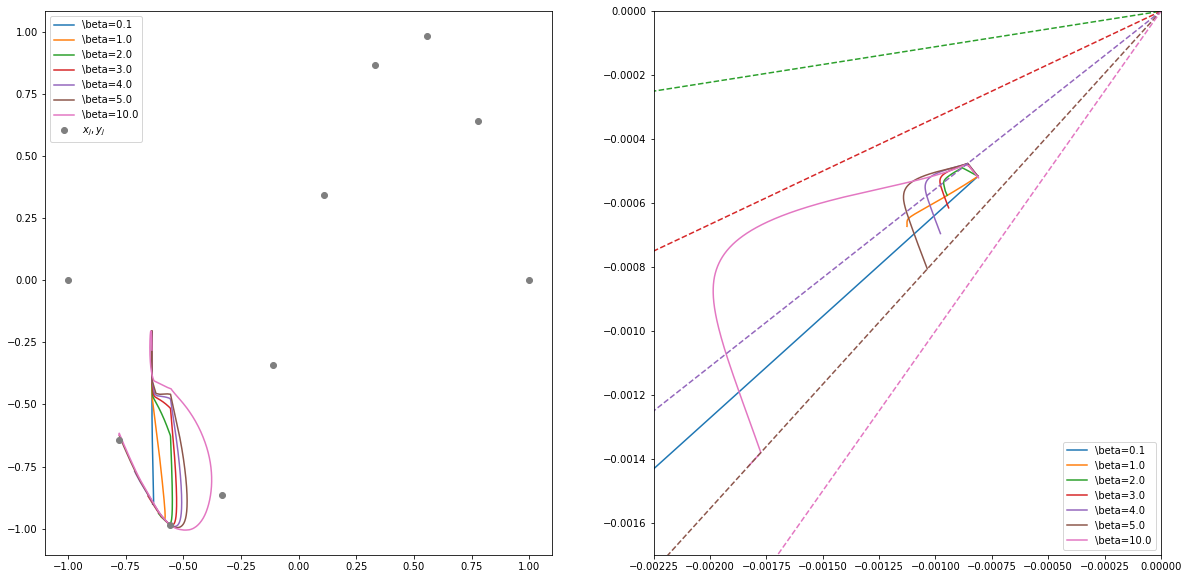

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize =(20, 10))

for beta in [1,10,20,30,40,50,100]:
    r,loss=var_beta(112,beta=beta,learning_rate = 0.0002,num_epochs=250000,dev=100)
    print(beta,loss)
    ax1.plot(r.T[1],r.T[3],'-',label=r'\beta='+str(beta/10))
    if beta==1:
        keepmodel=copy.deepcopy(model)
    
    
    
    rlod=np.zeros([3,len(r)])
    for i in range(len(r)):
        rlod[0,i]=r.T[0][i][0]
        
        rlod[1,i]=r.T[0][i][1]
        rlod[2,i]=r.T[0][i][2]
    r=rlod
    
    ax2.plot(r[0]*r[2],r[1]*r[2],'-',label=r'\beta='+str(beta/10))
    
    
ax1.plot(train_data,train_label,'o',label=r'$x_j,y_j$')
#model=keepmodel
#node_num=1000
#x= np.linspace(Nmin, Nmax, num=node_num)
#y= np.zeros(node_num)
#with torch.no_grad():
#    for i in range(node_num):
#        xx=torch.tensor(x[i]).reshape(-1, 1).to(device).float()
#        y[i]=model(xx).numpy()
#ax1.plot(x,y,'-',label=r'$x,f(x)$')


ax1.legend()
ax2.legend()

for i in train_data:
    dashline=np.linspace(-0.1, 0.1, num=10)
    ax2.plot(dashline,dashline*i,'--')
    
ax2.set_xlim([-0.00225,-0])
ax2.set_ylim([-0.0017,-0])


fig.savefig('node112(3).pdf')


In [ ]:
copy.deepcopy(model)

NeuralNet(
  (fc1): Linear(in_features=1, out_features=1000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1000, out_features=1, bias=False)
)